In [1]:
%reset -f 
%matplotlib notebook

# CS5228 Knowledge Discovery and Data Mining Final Project
## AY21/22 Semester 2

Chan Pei Shan / A0243461L	
Chua Mei Yun / A0131114A	
Goh Chee Hoe / A0227330R	
Lim Jun Yang Leonard / A0086792M


In [2]:
# --------------------------
# versions used
# --------------------------
# python          3.95
# numpy           1.22.0
# pandas          1.3.5
# scikit-learn    1.0.2
# matplotlib      3.5.1
# seaborn         0.11.2
# geopandas       0.10.2
# --------------------------

In [3]:
import os
import datetime
import re 

import numpy as np
import pandas as pd 
from pandas.api.types import is_string_dtype, is_numeric_dtype

from matplotlib import rcdefaults, pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, mean_squared_error, pairwise_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

# project specific functions
%reload_ext autoreload
%autoreload 2
from cs5228_project_support import *

# reset to to matplotlib defaults
rcdefaults()

# Data Import
---
In addition importing the available datasets, the [URA's Private Residential Property Transactions data](https://www.ura.gov.sg/realEstateIIWeb/transaction/search.action) was also scraped for additional data to validate the information in the available datasets.

In [4]:
datapath   = 'input'
auxpath    = os.path.join(datapath,'auxiliary-data')
outputpath = 'output'
submitpath = 'submissions'

# main train and test data file
df_train        = pd.read_csv(os.path.join(datapath,'train.csv'))
df_test         = pd.read_csv(os.path.join(datapath,'test.csv'))

# ura sales data from Jan 2021 to Jan 2022
df_ura          = pd.read_csv(os.path.join(auxpath,'ura.csv'))

# flag correction not done yet
corrected = False

this_year = datetime.datetime.now().year

## Basic Dataset Statistics
Point in dataset are quite diverse. Of the 26,408 records, the range of prices was between \\$74.8 million to just \\$560 thousand. The media was at \\$1.85 million, and the IQR is \\$1.62 million ( \\$2.95m - \\$1.33m ). What's interesting is that the standard deviation is \\$4.32million, almost 1.5 times that of the average of almost \\$3 million.

Looking just from the statistics, applying linear regression directly to this dataset would not yield the best prediction, because of the sensitivity to outliers. We would need to segragate the dataset into cohesive groups before applying linear regression.

In [5]:
df_train['pricesqft'] = df_train['price'] / df_train['area_size']

stats = []
print('Total number of observations : {:,}. (price in $millions)\n'.format(int(df_train['price'].describe()[0])))
stats.append(((df_train['price'].describe()/10**6)[1:,]).round(1))                # price in $ millions
stats.append(df_train[['area_size','pricesqft']].describe()[1:].astype(int))
print(pd.concat(stats,axis=1))

Total number of observations : 26,048. (price in $millions)

      price  area_size  pricesqft
mean    3.0       1248       2214
std     4.3       1066        785
min     0.6        226        181
25%     1.3        678       1667
50%     1.9        958       2081
75%     2.9       1356       2666
max    74.8      15000      18626


The price per square footage figure is useful to check for extremities or errors in the dataset. The mininmum and maximum of \\$181 and \\$18,626 are -2.6$\sigma$ and 21$\sigma$ away from the mean. This deserves investigation:  
* The -2.6$\sigma$ outlier comes from a single record of a Sky Habitat condominium costing over \\$2 million dolllars. It is listed as a 11,195 sq feet with only 2 bedrooms, when most of the other units in that development with 2 bedroom measures between 872 sq feet on the lower side to over just over 1,300 square feet. This is very likely a typographical error, and we propose to make the correcting to its square footage to 1,195. There is another record for Scotts Square of a similar error in its square footage, which we propose to correct to 624 square feet.

In [6]:
print('\n\nSky Habitat condo')
varlist = ['name','bedrooms','area_size','price', 'pricesqft']
filter1 = (df_train['name']=='sky habitat')
print( df_train[filter1][varlist])

print('\n\nScotts Square condo')
varlist = ['name','bedrooms','area_size','price', 'pricesqft']
filter1 = ( (df_train['name']=='scotts square') &  
           ( (df_train['area_size']==624.0) | (df_train['area_size']==6714.0) )
         )
print( df_train[filter1][varlist])



Sky Habitat condo
              name bedrooms  area_size      price    pricesqft
2013   sky habitat        2     1291.0  2398000.0  1857.474826
2204   sky habitat        3     1722.0  3278000.0  1903.600465
5413   sky habitat        2      710.0  1265000.0  1781.690141
5469   sky habitat        2      872.0  1622500.0  1860.665138
5873   sky habitat        2     1291.0  2398000.0  1857.474826
6036   sky habitat        4     3236.0  4818000.0  1488.875155
6422   sky habitat      2+1     1356.0  2088900.0  1540.486726
6809   sky habitat        2      890.0  1639000.0  1841.573034
8569   sky habitat      2+1     1291.0  2398000.0  1857.474826
8890   sky habitat        2     1291.0  2398000.0  1857.474826
9255   sky habitat      1+1      710.0  1485000.0  2091.549296
10274  sky habitat      4+1     1550.0  2493700.0  1608.838710
12210  sky habitat        2      872.0  1650000.0  1892.201835
12953  sky habitat      2+1     1206.0  1736500.0  1439.883914
13181  sky habitat        2    1119

* The +21$\sigma$ outlier comes from a single record of a Sky Vue condominium measuring 678 sq ft. recorded as more than \\$12.62 million, when the other units of the same square footage from the same development typically goes for between \\$1.2 and slightly over \\$1.4 million. This is very likely a typographical error, and we propose to make the correction to its price by 10X lower.

In [7]:
print('\n\nSky Vue condo')
varlist = ['name','bedrooms','area_size','price']
filter1 = (df_train['name']=='sky vue') & (df_train['area_size']==678.0) 
print( df_train[filter1][varlist])



Sky Vue condo
          name bedrooms  area_size       price
2716   sky vue        2      678.0   1408000.0
7500   sky vue        2      678.0   1408000.0
10137  sky vue        2      678.0   1417800.0
14116  sky vue        2      678.0   1320000.0
15240  sky vue        2      678.0   1417800.0
15927  sky vue        2      678.0   1196800.0
19666  sky vue        2      678.0   1408000.0
23675  sky vue        2      678.0   1397000.0
24169  sky vue        2      678.0   1408000.0
24939  sky vue        2      678.0  12629000.0


# Data Cleaning
---

In [8]:
# Make copy of data to work on
df_train_cleaned    = df_train.copy()
initial_nbr_records = df_train_cleaned.shape[0]
print('Before data cleaning: {} records.\n'.format(initial_nbr_records))

Before data cleaning: 26048 records.



#### Incorrectly coded districts
From close inspection of the training data, wrongly coded districts were discovered for some observations. This can be ascertain from inspection. The corrections involves the subzones of 'sentosa', 'sembawang springs', 'anson', 'pasir panjang 2', 'seletar hills', 'changi west','chatsworth', and 'clark quay'

Clark Quay district should be 9.

All the corrections wer made in consultation with the following sources:
[TeeCo's URA Planning Areas and Subzones](https://teeco.sg/ura-planning-areas-and-subzones/) map which is based on URA's Master Plan 2019 Subzone Boundary (No Sea) data set's indicative polygon of subzone boundaries.

In [9]:
df_train_cleaned = clean_districts(df_train_cleaned)

#### Incorrectly coded region, planning area and subzone
2 single entries corrections were also made for the properties named 'heritage east' and 'kent residences', using the same method of comparing entries with the same name, and observing the mode.

In [10]:
df_train_cleaned = clean_reg_pa_subzones(df_train_cleaned)

#### Correct the `market_segment` classifications

Correction s made based upon [URA classifcations](https://www.ura.gov.sg/reis/dataDictionary#C). Initial dataset was populated with OCR (Outisde Central Region) for all records.  
* **Central Region**: Central Region comprises the following 22 planning areas: _Downtown Core, Orchard, Marina East, Marina South, Museum, Newton, Outram, River Valley, Rochor, Singapore River, Straits View, Bishan, Bukit Merah, Bukit Timah, Geylang, Kallang, Marine Parade, Novena, Queenstown, Southern Islands, Tanglin and Toa Payoh_.  

* Core Central Region (CCR): CCR comprises: **districts 9, 10, 11**, the **Downtown Core** and **Sentosa** (in the Southern Island planning area) subzones.

* RCR refers to the Rest of Central Region; i.e. planning areas that are not defined as CCR.

In [11]:
df_train_cleaned = clean_mkt_segment_ura(df_train_cleaned)

#### Drop rows with NaN's for `area_size`
This is just 2 counts, and should not affect data quality.

In [12]:
df_eda_summary = pd.DataFrame()
df_train_cleaned = df_train_cleaned.dropna(subset = ['area_size'])
df_eda_summary['area_size'] = df_train_cleaned.isna().sum()

#### Split the N+M bedrooms netries
Creat a new feature `addrooms` to place the +M value. The `bedrooms` feature will retain the N value.

In [13]:
df_train_cleaned = clean_bedrooms_N_plus_M(df_train_cleaned)

#### Fill in 'built_year', 'no_of_units', 'bedrooms', and 'bathrooms' NaN's
The mode of the group of records is a good choice for filling these NaN's. This is becasue the property development and/or same type of units would very probably have the same feature values. For example, the number of units in a condiminium would be the same for that developement.  The following are the groupings use for each feature:
* by `name` for `model`, `built_year`, and `no_of_units`
* by [`name`,`area_size`] for `bedrooms`
* by [`name`,`bedrooms`] for `bathrooms`

In [14]:
df_train_cleaned = fillmode(df_train_cleaned,['name'],'model'                               )
df_train_cleaned = fillmode(df_train_cleaned,['name'],'built_year'           ,df_eda_summary)
df_train_cleaned = fillmode(df_train_cleaned,['name'],'no_of_units'          ,df_eda_summary)
df_train_cleaned = fillmode(df_train_cleaned,['name','area_size'],'bedrooms' ,df_eda_summary)
df_train_cleaned = fillmode(df_train_cleaned,['name','bedrooms'],'bathrooms' ,df_eda_summary)
df_train_cleaned = fillmode(df_train_cleaned,['bedrooms'],'bathrooms'        ,df_eda_summary)

In [15]:
# extract tenure down to 'freehold' or tenure length
df_train_cleaned['tenure'] = df_train_cleaned['tenure'].str.split('from').str[0]
df_train_cleaned = df_train_cleaned.assign(tenure = lambda dummy: dummy['tenure'].str.extract('(freehold|\d+)'))
df_train_cleaned = df_train_cleaned[df_train_cleaned['tenure'].notna()]

#### Corrections special cases (not to be applied to test dataset)

 Sky Vue area_size = 678, list for more than $12M when the going rate for same type of units in the development was 10X less.
 Suspect that this is a typographical error, and will correct it in place (divide price by 10).

 The -2.6 𝜎  outlier comes from a single record of a Sky Habitat condominium costing over $2 million dolllars. It is listed as a 11,195 sq feet with only 2 bedrooms, when most of the other units in that development with 2 bedroom measures between 872 sq feet on the lower side to over just over 1,300 square feet. This is very likely a typographical error, and we propose to make the correcting to its square footage to 1,195. # There is another record for Scotts Square of a similar error in its square footage, which we propose to correct to 624 square feet.


In [16]:
if not corrected:
    corrected = True
    varlist = ['name','bedrooms','area_size','price', 'pricesqft']
    
    # Sky Vue
    filter1 = (df_train_cleaned['name']=='sky vue') & (df_train_cleaned['area_size']==678.0) 
    max_price = df_train_cleaned[filter1]['price'].max()
    filter2 = filter1 & (df_train_cleaned['price']==max_price)
    df_train_cleaned.loc[filter2,'price'] = max_price/10.0
    df_train_cleaned.loc[filter2,'pricesqft'] = df_train_cleaned[filter2]['pricesqft'] / 10.0
    print( df_train_cleaned[filter1][varlist],'\n\n' )
    
    # Sky Habitat
    filter1 = (df_train_cleaned['name']=='sky habitat')
    max_size = df_train_cleaned[filter1]['area_size'].max()
    filter2  = filter1 & (df_train_cleaned[filter1]['area_size']==max_size)
    no_bedrooms = int(df_train_cleaned.loc[filter2,'bedrooms'])
    filter3  = filter1 & (df_train_cleaned[filter1]['bedrooms'].astype(int)==no_bedrooms) & \
                         (df_train_cleaned[filter1]['area_size']!=max_size)
    mean_size = round(df_train_cleaned[filter3]['area_size'].mean(),0)
    df_train_cleaned.loc[filter2,'area_size'] = mean_size
    df_train_cleaned.loc[filter2,'pricesqft'] = df_train_cleaned[filter2]['price'] / mean_size
    print( df_train_cleaned[filter1][varlist],'\n\n' )

    # Scotts Square
    filter1 = ( (df_train_cleaned['name']=='scotts square') &  
                ( (df_train_cleaned['area_size']==624.0) | (df_train_cleaned['area_size']==6714.0) ) )
    sizesqft = float(df_train_cleaned[filter1]['area_size'].mode())
    maxsqft = df_train_cleaned[filter1]['area_size'].max()
    filter2 = filter1 & (df_train_cleaned[filter1]['area_size']==maxsqft)
    print( df_train_cleaned[filter2][varlist] ) 
    df_train_cleaned.loc[filter2,'area_size'] = sizesqft
    df_train_cleaned.loc[filter2,'pricesqft'] = df_train_cleaned.loc[filter2,'price']/sizesqft
    print( df_train_cleaned[filter2][varlist] ) 
    print( df_train_cleaned[filter1][varlist],'\n\n' )
    
    # special case: 2 properties with `built_year` filled as 1799
    # 1. neu at novena - freehold and TOP in 2023 - to remove
    # 2. cuscaden reserve - 99-year Leasehold and completed in 2022 
    #    - retain and change `built_year` to 2022
    df_train_cleaned['built_year'] = df_train_cleaned['built_year'].replace(1799, 2022)

          name bedrooms  area_size      price    pricesqft
2716   sky vue        2      678.0  1408000.0  2076.696165
7500   sky vue        2      678.0  1408000.0  2076.696165
10137  sky vue        2      678.0  1417800.0  2091.150442
14116  sky vue        2      678.0  1320000.0  1946.902655
15240  sky vue        2      678.0  1417800.0  2091.150442
15927  sky vue        2      678.0  1196800.0  1765.191740
19666  sky vue        2      678.0  1408000.0  2076.696165
23675  sky vue        2      678.0  1397000.0  2060.471976
24169  sky vue        2      678.0  1408000.0  2076.696165
24939  sky vue        2      678.0  1262900.0  1862.684366 


              name bedrooms  area_size      price    pricesqft
2013   sky habitat        2     1291.0  2398000.0  1857.474826
2204   sky habitat        3     1722.0  3278000.0  1903.600465
5413   sky habitat        2      710.0  1265000.0  1781.690141
5469   sky habitat        2      872.0  1622500.0  1860.665138
5873   sky habitat        2     1

### Mark exclusive residential areas and subzones
The following were marked out as very exclusive residential areas where the prices per square feet are relatively high: newton','river valley','orchard','downtown core', and 'sentosa'. A new feature `excl_residential` is added for this identification.


In [17]:
df_train_cleaned = mark_excl_residential(df_train_cleaned)

### Merge URA dataset to calculate property's remaining leases and fill agency's other property information

1. Extracts lease start year from URA dataset  


2. Fill NaN's by using URA information as baseline, matched using lat/long. Updates NaN' in `built_year`, `no_of_units`,`name`, `type`, `model`, `tenure`, and `lease_start`  


3. Computed the lease left on the property.  
    The remaining lease on the property is computed to gauge how much 'life' is left for the property. Conventional wisdom says that the more lease remaining, the higher the price. For the case of freehold property, so as not to ascribe an overly large wieghtage on this metric, this class of properties is filled with a lease remaining of 999 years, which is practically the maximum for all long tenure properties in Singapore.

In [18]:
df_train_cleaned = merge_ura_dataset(df_train_cleaned, df_ura)
df_train_cleaned = fill_lease_and_ura_info(df_train_cleaned)
df_train_cleaned = compute_lease_left(df_train_cleaned)

### Computed standardized price metrics by subzones, planning areas and market segment

As there is a strong correlation of specific properties, properties within subzones, planning areas and market segment, there is a need to devise a metric to differentiate each property. The metric chosen is a standardized z-score for the price per square foot progressively against the mean of the next level of grouping. For exmaple, the price per square foot z-score is computed for a property against the subzone it is located in. At the next level, the z-score of the mean price per squate foot of the entire subzone is calculated against that for the entire planning area, that the subzone belongs to. This goes on up to the level of the market segment, In all, there are 3 price per square foot z-scores computed, i.e. `zprice_subzone`, `zprice_pa`, and `zprice_ms`. These metrics can be matched against the property itself and be mapped when prediction is done.

In [19]:
df_train_cleaned = compute_zprices(df_train_cleaned)
save_df(df_train_cleaned,outpath=outputpath)

### Summary of data cleaning done
Here a sumary of the changes made above and the number emaining NaN's left after the cleaning is done. The total number of records remaining after the cleaning phase is 25,360, out of the original 26,048 records provided. This is 97.4% of the records made useable for the regression task.

In [20]:
# print a summary
df_eda_summary['final'] = df_train_cleaned.isna().sum()
print('Number of NaN\'s after each stage of stage of cleaning')
print('=====================================================')
print(df_eda_summary)

Number of NaN's after each stage of stage of cleaning
                area_size  built_year  no_of_units  bedrooms  bathrooms  final
listing_id              0           0            0         0          0      0
name                    0           0            0         0          0      0
street                  0           0            0         0          0      0
type                    0           0            0         0          0      0
model                1279          24           24        24         24     22
market_segment          0           0            0         0          0      0
type_of_area            0           0            0         0          0      0
bedrooms              404         404          404       125        125    123
bathrooms            1235        1235         1235      1235         22     21
district                0           0            0         0          0      0
region                  0           0            0         0          0      

In [21]:
save_df(df_train_cleaned,outpath=outputpath)
print('After data cleaning:  {:,} records ({:2.1%} of original {:,}).\n'.format(df_train_cleaned.shape[0],
                                                                         df_train_cleaned.shape[0]/initial_nbr_records,
                                                                         initial_nbr_records))

After data cleaning:  25,760 records (98.9% of original 26,048).



# EDA
---

In [22]:
# make a copy from the cleaned data
df_eda = df_train_cleaned.copy()

#### Frequency and Box Plots binned by Price 
From this plot, we see that the resale market (all regions) is dominated by the class of condomimium costing between \\$1 million to $ 2 million. The box plot shows that there is significant the price per square foot overlap ranging across low to high total price of the property

<IPython.core.display.Javascript object>


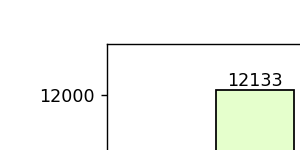

<IPython.core.display.Javascript object>


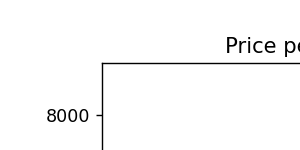

In [23]:
scale = 10**-6
data = df_eda['price']*scale
max_price = data.max()
bins_price = [0.0,1.0,2.0,3.0,4.0,5.0,7.5,10,max_price]
freq_plot(data,bins_price,'Price Frequency Plot','Price $ millions','Count','#E5FFCC')
boxplot_bin(df_eda,'pricesqft',scale,'price','cut',bins_price,
            'Price per Sq Feet Boxplot by Price Binning',
            'Price $ millions',
            'Price Per Sq Feet $')

df_eda['priceband'] = pd.cut(df_train_cleaned['price']*scale, bins=bins_price)

# Save in df_train_cleaned
df_train_cleaned['priceband'] = df_eda['priceband']
save_df(df_train_cleaned,outpath=outputpath)

#### Frequency and Box Plots binned by Square Footage
Here the binned frequency plot shows a concentration of resale units in the lower square footage class of properties. Similarly, there is significant overlap of the price per square foot across properties of all sizes.

<IPython.core.display.Javascript object>


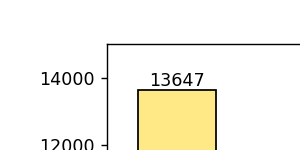

<IPython.core.display.Javascript object>


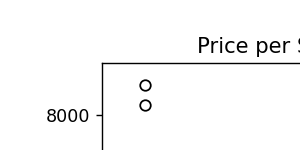

In [24]:
scale = 10**-3
data = df_train_cleaned['area_size']*scale
max_area = int(data.max())
bins_sqft = [0,1,1.5,2.0,2.5,3.0,4.0,5.0,max_area]
freq_plot(data,bins_sqft,'Floor Area Frequency Plot','Floor Area (thousands of sq. feet)','Count','#FFE886')
boxplot_bin(df_train_cleaned,'pricesqft',scale,'area_size','cut',bins_sqft,
            'Price per Sq Feet Boxplot by Floor Area Binning',
            'Floor Area (thousands of sq. feet)',
            'Price Per Sq Feet $')

df_eda['sqftband'] = pd.cut(df_eda['area_size']*scale, bins=bins_sqft)

# save in df_train_clean
df_train_cleaned['sqftband'] = df_eda['sqftband']
save_df(df_train_cleaned,outpath=outputpath)

### Frequency Plots

The price frequency plot tells us that most of records are clustered between 1 to 2 million dollars, followed by the next largest group between 2 and 3 million dollars.

<IPython.core.display.Javascript object>


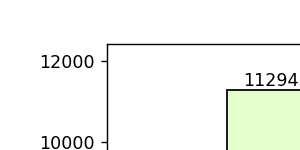

pricesqftband,"(0.0, 1.0]","(1.0, 2.0]","(2.0, 3.0]","(3.0, 4.0]","(4.0, 5.0]","(5.0, 6.5]","(6.5, 8.6]",All
market_segment,,,,,,,,
ccr,0,748,5433,2618,476,118,21,9414
ocr,290,7068,881,2,1,1,0,8243
rcr,21,3489,4249,317,14,13,0,8103
All,311,11305,10563,2937,491,132,21,25760


In [25]:
# Frequency plot and box plots
scale = 10**-3
data = df_eda['pricesqft']*scale
max_pricesqft = round(data.max(),1)
bins_pricesqft = [0.0,1.0,2.0,3.0,4.0,5.0,6.5,max_pricesqft]
freq_plot(data,bins_pricesqft,'pricesqft Frequency Plot','Price $ thousands','Count','#E5FFCC')

# cut data by pricesqft bands
df_eda['pricesqftband'] = pd.cut(df_eda['pricesqft']*scale, bins=bins_pricesqft)

# save in df_train_cleaned
df_train_cleaned['pricesqftband'] = df_eda['pricesqftband']
save_df(df_train_cleaned,outpath=outputpath)

# show crosstabs of pricesqft bands with market_segment
pd.crosstab(df_train_cleaned.market_segment, df_train_cleaned.pricesqftband,margins=True)

### Regression Predictors Correlation Plot

<IPython.core.display.Javascript object>


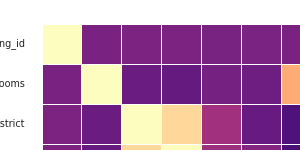

In [26]:
plot_correlation(df_train_cleaned)

### Name to Square Footage Price Mapping 

Create 2 mapping tables - separately mapping property development to `pricesqftband_*` and `zprice_*`. These 2 mapping will be use in the predictions. 

In [27]:
# Maps `name` to `pricesqftband_*`
pd_xtab_name_pricesqftband = pd.crosstab(df_train_cleaned.name, df_train_cleaned.pricesqftband, margins=False)
pd_xtab_name_pricesqftband['pricesqftband_pred'] = pd_xtab_name_pricesqftband.idxmax(axis=1, skipna=True)
pd_xtab_name_pricesqftband.insert (0, 'name', pd_xtab_name_pricesqftband.index)
pd_xtab_name_pricesqftband.reset_index(inplace=True, drop=True)
pd_xtab_name_pricesqftband = pd_xtab_name_pricesqftband[['name','pricesqftband_pred']]
save_df(pd_xtab_name_pricesqftband,outpath=outputpath)

df_train_cleaned = df_train_cleaned.merge( pd_xtab_name_pricesqftband,how='left',on='name',suffixes=['','_xtab'] )
df_eda           = df_eda.merge( pd_xtab_name_pricesqftband,how='left',on='name',suffixes=['','_xtab'] )

# Maps [`name`,`sqrtband`] to `pricesqftband_*` - may replace the above
pd_x_na_psfb = pd.crosstab([df_train_cleaned.name,df_train_cleaned.sqftband], df_train_cleaned.pricesqftband, margins=False)
pd_x_na_psfb['psfband_pred'] = pd_x_na_psfb.idxmax(axis=1, skipna=True)
pd_index = pd.DataFrame( list(pd_x_na_psfb.index), columns=['name','sqftband'] )
pd_x_na_psfb.reset_index(inplace=True, drop=True)
pd_x_na_psfb = pd.concat( [pd_index, pd_x_na_psfb], axis=1)
pd_x_na_psfb = pd_x_na_psfb[['name','sqftband','psfband_pred']]
save_df(pd_x_na_psfb,outpath=outputpath)

df_train_cleaned = df_train_cleaned.merge( pd_x_na_psfb,how='left',on=['name','sqftband'],suffixes=['','_xtab'] )
df_eda           = df_eda.merge( pd_x_na_psfb,how='left',on=['name','sqftband'],suffixes=['','_xtab'] )

# Maps `name` to `zprice_*`
xtab_name_zprice_cols = [ 'name','zprice_subzone', 'zprice_pa', 'zprice_ms']
pd_xtab_name_zprice = df_train_cleaned[xtab_name_zprice_cols].drop_duplicates(subset=['name'])
save_df(pd_xtab_name_zprice,outpath=outputpath)

### Geospatial Mapping of Pricing Bands

The geospatial mapping of the price by square footage shows a distinct locality feature. The 4 charts below shows this. It is obvious and reasonable that the higher price per sq foot is locate din the central region, particularly the core central region (CCR). Price could range from 3 to 8.6 thousand dollar per square foot. As the price per square foot falls into the band of 1 to 2 thousand dollars, the maps should that units are spread further out into the rets of the central region (RCR). The further away, particulary in the more remote western, northern and east and north eastern region price can fall to as little as below 1 thousand dollars per square feet.

<IPython.core.display.Javascript object>


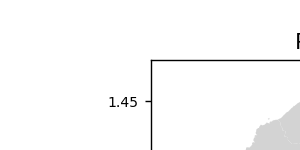

<IPython.core.display.Javascript object>


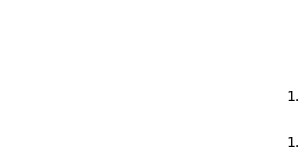

<IPython.core.display.Javascript object>


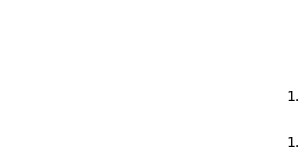

<IPython.core.display.Javascript object>


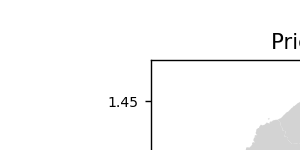

In [28]:
ura_all = gpd.read_file('maps/ura_2019_subzone_all.geojson')
ura_cr  = gpd.read_file('maps/ura_2019_subzone_cr.geojson')

ccr_filter = (df_eda['market_segment']=='ccr')
rcr_filter = (df_eda['market_segment']=='rcr')
ocr_filter = (df_eda['market_segment']=='ocr')
data_price_all = ( df_eda            ,ura_all,'lat','lng','pricesqftband','RdYlBu_r')
data_price_ccr = ( df_eda[ccr_filter],ura_cr ,'lat','lng','pricesqftband','RdYlBu_r')
data_price_rcr = ( df_eda[rcr_filter],ura_cr ,'lat','lng','pricesqftband','RdYlBu_r')
data_price_ocr = ( df_eda[ocr_filter],ura_all,'lat','lng','pricesqftband','RdYlBu_r')

plot_scatter_map(data_price_all,'Price per Sq Feet - All Regions'    ,'Thousands $ per Sq Foot')
plot_scatter_map(data_price_ccr,'Price per Sq Feet - Core Central'   ,'Thousands $ per Sq Foot')
plot_scatter_map(data_price_rcr,'Price per Sq Feet - Rest of Central','Thousands $ per Sq Foot')
plot_scatter_map(data_price_ocr,'Price per Sq Feet - Outside Central','Thousands $ per Sq Foot')

#### Geospatial Mapping of Amount of Lease Remaining 

The amount of lease left in the property can presumably play a role in determining the price. The following 4 maps shows the concentration of the various lease lengths. The maps shows the amount of lease left decrease as the properties are locate dfurther from the core central region (CCR). There is a particular concenration of high amoutn of remaing lease in the CCR.

<IPython.core.display.Javascript object>


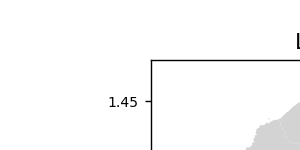

<IPython.core.display.Javascript object>


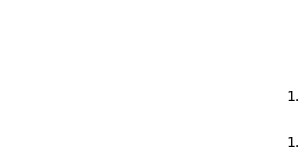

<IPython.core.display.Javascript object>


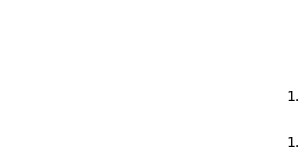

<IPython.core.display.Javascript object>


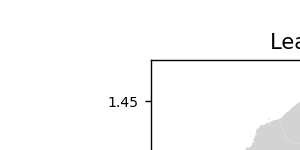

In [29]:
data_lease_all = ( df_eda[(df_eda['lease_left']<=1000)]           ,ura_all,'lat','lng','lease_left','viridis')
data_lease_ccr = ( df_eda[ccr_filter&(df_eda['lease_left']<=1000)],ura_cr ,'lat','lng','lease_left','viridis')
data_lease_rcr = ( df_eda[rcr_filter&(df_eda['lease_left']<=1000)],ura_cr ,'lat','lng','lease_left','viridis')
data_lease_ocr = ( df_eda[ocr_filter&(df_eda['lease_left']<=1000)],ura_all,'lat','lng','lease_left','viridis')

plot_scatter_map(data_lease_all,'Lease Remaining - All Regions'      ,'Lease Left (years)'     )
plot_scatter_map(data_lease_ccr,'Lease Remaining - Core Central'     ,'Lease Left (years)'     )
plot_scatter_map(data_lease_rcr,'Lease Remaining - Rest of Central'  ,'Lease Left (years)'     )
plot_scatter_map(data_lease_ocr,'Lease Remaining - Outside Central'  ,'Lease Left (years)'     )

In [30]:
# save copy of the EDA and cleaned training dataframe
save_df(df_train_cleaned,outpath=outputpath)
save_df(df_eda          ,outpath=outputpath)

## Preprocessing

---

In [31]:
# preprocess for linear regression: add LR variables (dummies)
# structure split data for regression
lr_col      = ['market_segment','excl_residential','area_size','sqftband','pricesqft',
               'pricesqftband_pred','psfband_pred','pricesqftband','lease_left']
key         = ['market_segment','excl_residential','area_size','lease_left']
others      = []
sqftbands   = list(df_eda.columns[df_eda.columns.str.startswith('sqftband_')])
auxillaries = list(df_eda.columns[df_eda.columns.str.startswith('num_')])
pricebands  = list(df_eda.columns[df_eda.columns.str.startswith('pricesqftband_')])
zprices     = ['zprice_subzone','zprice_pa','zprice_ms']

df_train_preproc = df_eda[['name','lat','lng']+lr_col+auxillaries+zprices].copy()

df_train_preproc = categorize(df_train_preproc,'market_segment', [['ocr', 'rcr', 'ccr']],keep_col=True)
df_train_preproc = pd.get_dummies(df_train_preproc, columns=['sqftband'],drop_first=True)
df_train_preproc = pd.get_dummies(df_train_preproc, columns=['pricesqftband'],drop_first=True)
df_train_preproc = pd.get_dummies(df_train_preproc, columns=['pricesqftband_pred'],drop_first=True)
df_train_preproc = pd.get_dummies(df_train_preproc, columns=['psfband_pred'],drop_first=True)

df_train_preproc = preproc_auxilliary(df_train_preproc)
save_df(df_train_preproc,outpath=outputpath)

print('After preprocessing: {:,} records.'.format(df_train_preproc.shape[0]))

After preprocessing: 25,760 records.


## Finalized Linear Regression Predictors

From the exploratory data analysis showing the strong correlation of price with specific properties and locations, we have decided to use the following as predictors **selectively** for the regression task. Also included are the various auxillaries computed from the auxillary datasets provided.

| Predictors        	    | Description                                                         |
| :-:	                    | ---                                                                 |
| `market_segment*`   	    | `market_segment` regression categorical                             |
| `area_size`    			| Square footage - floor area                                         |
| `sqftband_*`              | Square footage bands                                                |
| `excl_residential`        | Exclusive residential planning areas and subzones                   |
| `lease_left`              | Remaining lease on the property                                     |
| `pricesqftband_*`         | Actual observed psf bands (raw data)                                |
| `pricesqftband_pred_*`    | Remapped psf band by `name`                                         |
| `psfband_pred_*`          | Remapped psf band by `name` and `sqft_band_*`                       |
| `zprice_*`                | z-score of prices within subzones, planning area and market segment |
| `num_comm_centre`    		| Number of commerical centres within in 5km                          |
| `num_market_hawker`    	| Number of markets and hawker centres within 400m                    |
| `num_pri_sch`			    | Number of primary schools within 1km                                |
| `num_sec_sch`    			| Number of secondary schools within 1km                              |
| `num_mall`	    		| Number of malls within 2km                                          |
| `num_mrt`		    		| Number of mrts within 400m                                          |

In [32]:
# split dataset
np.random.seed(0)
train, test = train_test_split(df_train_preproc, test_size=0.2)

# structure split data for regression
key             = ['area_size', 'excl_residential','lease_left']
segments        = list(train.columns[train.columns.str.startswith('market_segment_')])
sqftbands       = list(train.columns[train.columns.str.startswith('sqftband_')])
pricebands      = list(train.columns[train.columns.str.startswith('pricesqftband_(')])
pricebands_pred = list(train.columns[train.columns.str.startswith('pricesqftband_pred_')])
psfbands_pred   = list(train.columns[train.columns.str.startswith('psfband_pred_')])
auxillaries     = list(train.columns[train.columns.str.startswith('num_')])
zprices         = ['zprice_subzone','zprice_pa','zprice_ms']

# response and scaling factor
response    = 'pricesqft'
rscaler     = 'area_size'

# ============
# predictor lists for training
# ============
predictors_t0 = key + segments + sqftbands + auxillaries
predictors_t1 = predictors_t0 + zprices + pricebands
# -----
# 1. overall regression, no splits
# -----
ssplits = []
ssplit_dataset_t0 = x_split( (train,test), ssplits, predictors_t0, response, rscaler )
# -----
# 2. market segment splits
# -----
msplits = []
msplits.append( ( (train.market_segment=='ccr'), (test.market_segment=='ccr') ) )
msplits.append( ( (train.market_segment=='rcr'), (test.market_segment=='rcr') ) )
msplits.append( ( (train.market_segment=='ocr'), (test.market_segment=='ocr') ) )
msplit_dataset_t0 = x_split( (train,test), msplits, predictors_t0, response, rscaler )
msplit_dataset_t1 = x_split( (train,test), msplits, predictors_t1, response, rscaler )

# ============
# predictor lists for validation with test.csv
# ============
predictors_p0 = predictors_t0 + zprices + pricebands_pred                # maps using only name
ssplit_dataset_p0 = x_split( (train,test), ssplits, predictors_p0, response, rscaler )
msplit_dataset_p0 = x_split( (train,test), msplits, predictors_p0, response, rscaler )

predictors_p1 = predictors_t0 + zprices + psfbands_pred                  # maps using      name + sqftbands
ssplit_dataset_p1 = x_split( (train,test), ssplits, predictors_p1, response, rscaler )
msplit_dataset_p1 = x_split( (train,test), msplits, predictors_p1, response, rscaler )

# ============
# base estimaters settings 
# ============
lrargs  = {'fit_intercept':True, 'n_jobs':8}
rfargs  = {'n_estimators':100, 'random_state':0}
adaargs = {'base_estimator':LinearRegression(**lrargs), 'random_state':0}
gbargs  = {'n_estimators':100, 'random_state':0}

### 1. Standard Regression with overall dataset

A first regression is run with the entire dataset, without splitting into different market segments that are regressed individually before recombining them. The regression results shows a relatively high RSME at $1.37M. The regression also shows a marginal response from the variable `market_segment_1` (a catgeory variable of the `market_segment` variable) and the `excl_residential` variable that singles out exclusive residential areas in the planning areas of 'newton', 'river valley', 'orchard', 'downtown core','sentosa' of the core central region (CCR). There is also a relatively strong response from the banding variables built from the properties square footage `sqftband_*`. 

Contrary to initial expoectations, the length of lease remaining does not contribute much to additonal marginal price per square feet.

Overall, the regression results confirms the initial anlaysis that prices are strongly correlated to location and size, and less so towards the surround facilities. This can be reasoned as the tacit knowledge of those facilities are already 'priced' into the value of the property, and therefore does not shows the level of response as for location related and property specific variables.

In [33]:
lr_results, overallRMSE = multiple_regressor( ssplit_dataset_t0, LinearRegression, **lrargs)
display_lr_parameters(lr_results,overallRMSE)

Overall RMSE : 1,367,816

                     Regressor :          1
                          RSME :  1,367,816

                     intercept :    1,342.5
                     area_size :        0.2
              excl_residential :      310.2
                    lease_left :        0.3
              market_segment_1 :      376.6
           sqftband_(1.0, 1.5] :     -181.3
           sqftband_(1.5, 2.0] :     -289.7
           sqftband_(2.0, 2.5] :     -215.1
           sqftband_(2.5, 3.0] :     -170.7
           sqftband_(3.0, 4.0] :     -231.6
           sqftband_(4.0, 5.0] :     -404.9
          sqftband_(5.0, 15.0] :     -194.4
               num_comm_centre :       29.7
             num_market_hawker :      -59.8
                   num_pri_sch :      -86.8
                   num_sec_sch :       44.5
                      num_mall :        9.8
                       num_mrt :       33.6


### 2. Multiple Regression with split dataset

To analyse the location relationship further, a second regression on the overall dataset is run. This time, we split the dataset into the 3 market_segments, i.e. CCR, RCR, and OCR, to be regressed separately. The market segments of CCR, RCR and OCR  are matched with Regressor 1, 2 and 3 respectively in the regression result below. This is done to see if there is any difference in the overal RMSE and if there is disparity in the RMSE between the various market segments. In short, the 3 regressor objects will be returned which corresponds to the 3 mark segments

The combined results from the multiple regression still shows shows a relatively high RSME at $1.25M, which is a little less that when all the market segments are regressed together. This validates that market segmentation is a significant predictor. Teh details results actually shows that the `market_segment_1` variable is marginally zero because the regression is now run separately for each region which is to be expected.

We further observed the following:  

1. segment level RMSE is now lowered then the market average at \\$850K and \\$360K for the RCR and OCR regions. Correspondingly, the RMSE for the CCR region is higher at \\$2M indicating that there is a high level of variance in the square footage price within the segment.  


2. Further to the higher variance in the CCR segment causing the higher RMSE, the marginal response from the `excl_residential` variable indicates those valued planning areas is driving the square footage prices in CCR.


3. The responses from the banding variables `sqftband_*` is divesified across the segments, indicating that this is a driver of square footage prices. For example, in OCR, the properties that are larger in square footage terms ( 3 thousand square feet or higher) are priced marginally higher that the smaller properties that are smaller than 2 thousand sqaure feet.

Overall, the regression results further confirms the initial anlaysis, and other predictors needs to be used to account for the price variance in CCR, so that the RMSE for CCR can be lowered, which will in turn lowered the overall market level RMSE.

In [34]:
lr_results_multi, overallRMSE_multi = multiple_regressor( msplit_dataset_t0, LinearRegression, **lrargs)
display_lr_parameters(lr_results_multi,overallRMSE_multi)

Overall RMSE : 1,249,827

                     Regressor :          1         2         3
                          RSME :  1,872,488   848,365   323,060

                     intercept :    1,624.4   2,371.0   1,551.5
                     area_size :        0.1       0.3      -0.3
              excl_residential :      350.1       0.0       0.0
                    lease_left :        0.3       0.0       0.3
              market_segment_1 :        0.0      -0.0      -0.0
           sqftband_(1.0, 1.5] :      -23.5    -333.4     -65.4
           sqftband_(1.5, 2.0] :     -156.7    -502.9      37.1
           sqftband_(2.0, 2.5] :       94.2    -723.7     -94.8
           sqftband_(2.5, 3.0] :      127.6    -482.4     135.0
           sqftband_(3.0, 4.0] :      252.3    -850.1     437.6
           sqftband_(4.0, 5.0] :       61.6  -1,164.5     648.9
          sqftband_(5.0, 15.0] :      418.9  -1,537.0     930.2
               num_comm_centre :      125.5     -67.0      15.4
             

### 3. Square Footage Price Predictors in Multiple Regression

In this third training phase analysis, we include the following 2 price metric as predictors:  

1. `zprice_subzone`, `zprice_pa`, and `zprice_ms`. These 3 metrics predictors are designed to address the strong correlation of specific properties, properties within subzones, planning areas and market segment. These are z-score for the price per square foot progressively against the mean of the next level of grouping. The intuition is that these metric predictors can be matched against the property itself and be mapped when prediction is done.  


2. `pricesqftband_*`. There predictors are derived from the grouping of the square footage price into various bands. This predictors is another angle to allow the the regression to identify pricing variances. However, for the purpose of prediction, where the price of the property is obviously not available, it is expetced that we may again match this to the specific properties and therefore we will be able to cluster the property develpments (by their names) for matching back to the price banding clusters.  

**Results and Observations**

The combined results from regression with the added price metric realated predictors shows a much lower overall RSME of \\$370K, as compared to $1.37M previously. Individally, each of the segment RMSE have also fallen, with the largest decrease for CCR at roughly 4 times, as compared to that for RCR and OCR at approximately 2X (which is still significant). This indicates at the overall level, that the price related predictors are the right metric to drive prediction. This is even more evident for CCR which has the highest price variance, indicating that price variance within CCR is highly correlated to the price-related predictors. 


1. Comparing `zprice_*` and `pricesqftband_*`, the latter has the greatest marginal response, and differentiates the segments from each other. Take CCR for example, the marginal response from price bands upwards of \\$5K per square feet is positively higher versus that of the lower price bands. All these are measure against the reponse from the refernce level ( the band that is less than \\$1K per square feet).


2. The marginal reponse form the predictor `excl_residential` now is less pronounced (it was previously aproximate \\$317 per square foot but has decreased to \\$30.9 per square foot. This incidcates that the gross metric in this predictor has now been assumed by `zprice_*` and `pricesqftband_*`, with the larger proportion of the marginal response embedded in the latter.

In [35]:
lr_results_multi, overallRMSE_multi = multiple_regressor( msplit_dataset_t1, LinearRegression, **lrargs)
display_lr_parameters(lr_results_multi,overallRMSE_multi)

Overall RMSE :  370,134

                     Regressor :          1         2         3
                          RSME :    521,022   299,630   157,255

                     intercept :    3,842.0   1,594.3   1,551.4
                     area_size :        0.0      -0.1      -0.2
              excl_residential :       32.1       0.0      -0.0
                    lease_left :       -0.0      -0.0       0.0
              market_segment_1 :        0.0      -0.0      -0.0
           sqftband_(1.0, 1.5] :      -41.8      -7.6      16.8
           sqftband_(1.5, 2.0] :      -25.4      28.3      41.0
           sqftband_(2.0, 2.5] :      -20.8      61.8     -10.1
           sqftband_(2.5, 3.0] :      -42.3     210.8     133.3
           sqftband_(3.0, 4.0] :       -9.9     201.1     133.5
           sqftband_(4.0, 5.0] :        1.0     373.9     283.3
          sqftband_(5.0, 15.0] :       73.6     515.1     686.3
               num_comm_centre :        6.1      -8.7       1.8
             n

### 4. Multiple Regression with Mapping of Property to Square Footage Price Predictors

`pricesqftband_pred*`. This new set predictors is added to the training data by grouping the properties that have the highest occurence in the at the original `pricesqftband_*` predictors. As is expected, some of the property development are spread across square footage price bands, but this is expected to be a small set of the total dataset. The rationale for doing this is that the validation test set (test.csv) will not contain the price information, and we are using the surrogate of the property development (by its `name`) as a good representative clustering as the `pricesqftband_*` predictors do.

From this, we will run another multple regression with the `pricesqftband_*` replaced by `pricesqftband_pred*`.

**Results and Observations**

With the predictor changed, the multple regression shows a higher RMSE at \\$812K (as compaed with \\$370K). This is to be expected as the clusters are now not conforming to the original grouping that the banding that the `pricesqftband_*` predictors provided. This is however still much improved from the \\$1.25M RMSE when no grouping were done at the property development level. 

At the market segemnt level, the `pricesqftband_pred*` predictors are less sensitive than the `pricesqftband_*`, which shows that the translation from actual square footage price bands to the surrogate price classification using property development degrades the regression results. This also means that there are features within each property development is is driving the its value. That is to say that different units within the same development exhibits different value which are not captured by being in that development itself. Such predictors could come in the form of the level teh units is at, the floor area of the unit etc.

In summary, using `pricesqftband_pred*` as predictors would be a compromise that can be possibily be acceptable.

In [36]:
lr_results_multi, overallRMSE_multi = multiple_regressor( msplit_dataset_p0, LinearRegression, **lrargs )
display_lr_parameters(lr_results_multi,overallRMSE_multi)

Overall RMSE :  812,556

                     Regressor :          1         2         3
                          RSME :  1,217,954   564,910   164,146

                     intercept :    3,079.3   1,904.9   1,709.7
                     area_size :        0.0       0.3      -0.2
              excl_residential :       57.5       0.0      -0.0
                    lease_left :       -0.0       0.0       0.0
              market_segment_1 :        0.0       0.0       0.0
           sqftband_(1.0, 1.5] :      -68.5    -241.1      25.6
           sqftband_(1.5, 2.0] :      -77.3    -394.9      48.6
           sqftband_(2.0, 2.5] :      -22.8    -495.4      14.2
           sqftband_(2.5, 3.0] :       -1.9    -475.7     178.7
           sqftband_(3.0, 4.0] :       42.9    -688.0     231.8
           sqftband_(4.0, 5.0] :       93.7  -1,031.5     341.0
          sqftband_(5.0, 15.0] :      402.8  -1,240.7     745.9
               num_comm_centre :       13.9      -5.3       1.5
             n

###  Including Square Footage as a mapping for the Square Footage Price Predictors surrogate

It was observed that there is some pricing variation that could come by virtue of the size of the property. The original mapping key was by the property development `name` alone. For this variation, an additional key is included to differentiate various variants of unit floor area within the development, for evetually mapping back to the square footage price range.

**Results and Observations**

Indeed with the additional dimension, the multple regression shows a lower RMSE at \\$610K (as compaed with \\$812K above), incidcatinbg the floor area indeed affects the pricing of the property. 

In [37]:
lr_results_multi, overallRMSE_multi = multiple_regressor( msplit_dataset_p1,LinearRegression, **lrargs )
display_lr_parameters(lr_results_multi, overallRMSE_multi)

Overall RMSE :  610,515

                     Regressor :          1         2         3
                          RSME :    849,742   549,112   166,372

                     intercept :    3,551.2   1,490.2   1,638.8
                     area_size :        0.0       0.3      -0.2
              excl_residential :       25.9       0.0       0.0
                    lease_left :        0.0      -0.0       0.0
              market_segment_1 :       -0.0      -0.0      -0.0
           sqftband_(1.0, 1.5] :      -63.2    -208.1      22.5
           sqftband_(1.5, 2.0] :      -46.7    -330.2      47.0
           sqftband_(2.0, 2.5] :      -41.1    -465.0       7.0
           sqftband_(2.5, 3.0] :      -59.2    -448.3     161.1
           sqftband_(3.0, 4.0] :       13.6    -740.7     163.5
           sqftband_(4.0, 5.0] :        6.4    -940.1     323.2
          sqftband_(5.0, 15.0] :       94.3  -1,113.5     760.1
               num_comm_centre :        5.0      -8.3       1.8
             n

### 5. Checking Mapping of Property to Square Footage Price Predictors Against Standard Regression (Overall Market)

As a final check, we will run the finalized predictors on standard regression without the market segment differentiation as in (1) above.

The results, as in the cases for the multiple regression cases, shows marked improvements over the case when the price predictors were not regressed against. The results is also slightly worse than that for the multiple regression scenario in (4) above, increasing RMSE by about \\$40K.

In summary, using `pricesqftband_pred*`, which clusters property developments as a surrogate, as predictors is a good choice.

In [38]:
lr_results, overallRMSE = multiple_regressor( ssplit_dataset_p0,LinearRegression, **lrargs )
display_lr_parameters(lr_results,overallRMSE)

Overall RMSE :  841,863

                     Regressor :          1
                          RSME :    841,863

                     intercept :    1,636.5
                     area_size :        0.1
              excl_residential :       88.5
                    lease_left :        0.0
              market_segment_1 :      494.8
           sqftband_(1.0, 1.5] :     -106.2
           sqftband_(1.5, 2.0] :     -196.3
           sqftband_(2.0, 2.5] :     -220.8
           sqftband_(2.5, 3.0] :     -181.1
           sqftband_(3.0, 4.0] :     -269.8
           sqftband_(4.0, 5.0] :     -339.7
          sqftband_(5.0, 15.0] :      -98.5
               num_comm_centre :        3.6
             num_market_hawker :      -14.7
                   num_pri_sch :       -4.3
                   num_sec_sch :        0.8
                      num_mall :       -0.6
                       num_mrt :        1.8
                zprice_subzone :      299.9
                     zprice_pa :      357.2
      

###  with square footage as mapping key

As was the case of the multiple regressor, the same level of decrease in the RMSE of about \\$150K was observed for the unsplit test dataset.

In [39]:
lr_results, overallRMSE = multiple_regressor( ssplit_dataset_p1,LinearRegression, **lrargs )
display_lr_parameters(lr_results, overallRMSE )

Overall RMSE :  591,108

                     Regressor :          1
                          RSME :    591,108

                     intercept :    1,450.8
                     area_size :        0.1
              excl_residential :       20.4
                    lease_left :       -0.0
              market_segment_1 :      446.7
           sqftband_(1.0, 1.5] :      -98.7
           sqftband_(1.5, 2.0] :     -160.4
           sqftband_(2.0, 2.5] :     -235.7
           sqftband_(2.5, 3.0] :     -232.4
           sqftband_(3.0, 4.0] :     -303.6
           sqftband_(4.0, 5.0] :     -390.0
          sqftband_(5.0, 15.0] :     -398.6
               num_comm_centre :        0.5
             num_market_hawker :       -7.3
                   num_pri_sch :       -5.1
                   num_sec_sch :        1.4
                      num_mall :       -0.1
                       num_mrt :       -3.4
                zprice_subzone :      255.3
                     zprice_pa :      314.0
      

## Comparison with Prebuilt Ensemble Regressors

In the section we compare our rudimentary ground up approach with pre-built ensemble regressors from [scikit-learn Ensemble Methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), specifically the following:

1. [AdaBoost Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)
2. [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
3. [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

The test method will focus on using just the same training dataset that has been cleaned, prepared, and used for the ground up regressors. This will ensure that we are keeping the inputs the same so that we can compared the results reliably. A similar tack will be taken for preparing the validatation test dataset. The default on setting will also be applied for all the ensemble regressors used.

**Results**

The pre-built Random Forest Regressor on default settings performed the best both on training and in the validation. Both training and validation scores were close, which shows that the default settings genralizes quite well. A similar outcome can also be seen for the Gradient Boosting Regressor. Coming in third is the ground-up Multiple Regressor on split dataset, which also generalizes quite well for the validation test dataset. However, the overall performance, of this regressor is not as good as that for the 2 pre-built regressors. The last 2 regressors are the Single Regressor on unsplit dataset and the pre-built AdaBoost regressor. Both did not genralize as well as the first three, providing validation results ion terms of RMSE that were almost twice as much as the training RMSE.

| Regressor Used                     | train RMSE | validation RMSE|
|------------------------------------|------------|----------------|
| sklearn Random Forest Regressor    |    382K    |      432K      |
| sklearn Gradient Boosting Regressor|    498K    |      540K      |
| Multiple Regressor - split data    |    610K    |      701K      |
| Single Regressor - unsplit data    |    591K    |      957K      |
| sklearn AdaBoost Regressor         |    676K    |     1.01M      |

We believe that the Multiple Regressor, even though had a seemingly correct approach in performing multiple regression (with the help of a base regressor in the LinearRegression class), in the same fashion as the Random Forest Regressor, suffers from a lack of good, appropriate, and data-insightful choices of predictors. It needs improvemnts in being able to appropriately segregate the dataset so that the linear regression task can do the work it is designed for. Overall impurity in the dataset splits needs to be reduced, especially so for the data points within the CCR.

The Single Regressor suffers from relying completely on linear regression to perform its task. This is made difficult by the diversity displayed in the dataset. There is much hidden information within the dataset for the standard linear regression setup to perform well. To solve this problem would mean having to head craft predictors that would be non linear and perhaps interaction between the predictors. This would be a task that would take much prior knowledge, time and effort to perform. As simply demonstrated here, the Random Forest regressor, even in its default settings, would be able to perform the task better and quick than can be done by the Single Regressor.


### Random Forest Regressor

In [40]:
lr_results_rf, overallRMSE_rf = multiple_regressor( ssplit_dataset_p1,RandomForestRegressor,**rfargs )
print('RMSE = {:,.0f}'.format(overallRMSE_rf))

RMSE = 382,376


### Adaboost Regressor

In [41]:
lr_results_ada, overallRMSE_ada = multiple_regressor( ssplit_dataset_p1,AdaBoostRegressor,**adaargs )
print('RMSE = {:,.0f}'.format(overallRMSE_ada))

RMSE = 670,726


### Gradient Boosting Regressor

In [42]:
lr_results_grad, overallRMSE_grad = multiple_regressor( ssplit_dataset_p1,GradientBoostingRegressor,**gbargs )
print('RMSE = {:,.0f}'.format(overallRMSE_grad))

RMSE = 501,667


## Prediction on Validation Test Dataset

### 1. Clean and Augment Test Dataset

The validation test dataset is cleaned and proprocess according to the same process done for teh trainign dataset.

In [43]:
df_test_cleaned  = df_test.copy()

# Clean test dataset and preprocess dataset according to training run
df_test_cleaned = clean_districts(df_test_cleaned)
df_test_cleaned = clean_reg_pa_subzones(df_test_cleaned)
df_test_cleaned = clean_mkt_segment_ura(df_test_cleaned)
df_test_cleaned = clean_bedrooms_N_plus_M(df_test_cleaned)

# fill mode to prevent NaN's
group_col_pairs = [ (['name'],'model'), (['name'],'built_year',), ( ['name'],'no_of_units'),
                    (['name','area_size'],'bedrooms'), (['name','bedrooms'],'bathrooms'), 
                    (['bedrooms'],'bathrooms')                                                ]
fillmode_by_pairs(df_test_cleaned, group_col_pairs)

# Compute avilable information on leases (will be augmented by URA information later)
df_test_cleaned['model'].fillna(df_test_cleaned['type'],inplace=True)
df_test_cleaned['tenure'] = df_test_cleaned['tenure'].str.split('from').str[0]
df_test_cleaned = df_test_cleaned.assign(tenure = lambda dummy: dummy['tenure'].str.extract('(freehold|\d+)'))

# mark exclusive residential zones
df_test_cleaned = mark_excl_residential(df_test_cleaned)

# merge URA dataset - fill NaN's and computed remaining leases
df_test_cleaned = merge_ura_dataset(df_test_cleaned, df_ura)
df_test_cleaned = fill_lease_and_ura_info(df_test_cleaned)
df_test_cleaned = compute_lease_left(df_test_cleaned)

# create `area_size` banding 
df_test_cleaned['sqftband'] = pd.cut(df_test_cleaned['area_size']*10**-3, bins=bins_sqft)

# merge pricesqftband surrogate (fill NaN's will the mode of the subszone, planning_area, or region)
# merge psfband (name,sqftband) surrogate (fill NaN's will the mode of the subszone, planning_area, or region)
# merge zprice_* (fill NaN's will the mode of the subszone, planning_area, region)
df_test_cleaned = df_test_cleaned.merge( pd_x_na_psfb,how='left',on=['name','sqftband'],suffixes=['','_xtab'] )
df_test_cleaned = df_test_cleaned.merge( pd_xtab_name_pricesqftband,how='left',on='name',suffixes=['','_xtab'] )
df_test_cleaned = df_test_cleaned.merge( pd_xtab_name_zprice,how='left',on='name',suffixes=['','_xtab'] )

# fill mode by zones to account for validation records not in the training dataset
zones       = ['subszone','planning_area','region']                            # order is important (?)
merged_cols = ['psfband_pred','pricesqftband_pred','zprice_subzone','zprice_pa','zprice_ms']
df_test_cleaned = fillmode_by_zone(df_test_cleaned,merged_cols,zones)

# compute auxillary data values
df_test_cleaned = preproc_auxilliary(df_test_cleaned)

#save a copy
save_df(df_test_cleaned,outpath=outputpath)

### 2. Preprocess for Prediction
The validation test dataset is preprocessed for prediction according to the procedure done to training dataset

In [44]:
df_test_preproc = df_test_cleaned.copy()

# consolidate predictors
key_pred         = ['market_segment_1','excl_residential','area_size','lease_left']
m_key_pred       = ['market_segment'] + key_pred
lr_col_pred      = ['market_segment','excl_residential','area_size','lease_left','sqftband','pricesqftband_pred','psfband_pred' ]
sqftbands_pred   = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('sqftband_')])
auxillaries_pred = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('num_')])
pricebands_pred  = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('pricesqftband_pred_')])
psfbands_pred    = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('psfband_pred_')])
zprices_pred     = ['zprice_subzone','zprice_pa','zprice_ms']

# columns to be used for prediction
data_cols_pred   = lr_col_pred + auxillaries_pred + zprices_pred
df_test_preproc = df_test_preproc[data_cols_pred].copy()

df_test_preproc = categorize( df_test_preproc,'market_segment', [['ocr', 'rcr', 'ccr']],keep_col=True )
df_test_preproc = pd.get_dummies( df_test_preproc, columns=['sqftband'],drop_first=True )
df_test_preproc = pd.get_dummies( df_test_preproc, columns=['pricesqftband_pred'],drop_first=True )
df_test_preproc = pd.get_dummies( df_test_preproc, columns=['psfband_pred'],drop_first=True )

#save copy
save_df(df_test_preproc,outpath=outputpath)

### 3. Prepare Dataset Splits

In [45]:
# split dataset
np.random.seed(0)

sqftbands_pred   = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('sqftband_')])
auxillaries_pred = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('num_')])
pricebands_pred  = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('pricesqftband_pred_')])
psfbands_pred    = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('psfband_pred_')])
psfprob          = list(df_test_preproc.columns[df_test_preproc.columns.str.startswith('psfprob_')])

# ============
# predictor lists for validation
# ============
s_predictors_v = key_pred + sqftbands_pred + auxillaries_pred + zprices_pred + pricebands_pred + psfbands_pred
m_predictors_v = m_key_pred + sqftbands_pred + auxillaries_pred + zprices_pred + pricebands_pred + psfbands_pred
m_predictors_v2 = m_key_pred + sqftbands_pred + auxillaries_pred + zprices_pred + pricebands_pred + psfbands_pred + psfprob

# scaling factor
rscaler     = 'area_size'

# dataset
test_v = df_test_preproc.copy()

# build data splits
# -----
# 1. no split = single split is a list of no split
# -----
s_splits_v = [ pd.Series([True] * len(test_v) , dtype=bool, index=test_v.index ) ]

# -----
# 2. market segment
# -----
m_splits_v = []
m_splits_v.append( (test_v.market_segment=='ccr') )
m_splits_v.append( (test_v.market_segment=='rcr') )
m_splits_v.append( (test_v.market_segment=='ocr') )

### 4. Generate Predictions

In [46]:
# Single Regressor
single_reg_submission = multi_prediction( lr_results, test_v, s_splits_v, rscaler, df_test_cleaned, prefix='s' )
save_df( single_reg_submission, outpath=submitpath, index_label='Id' )

# Multiple Regressor
multi_reg_submission = multi_prediction( lr_results_multi, test_v, m_splits_v, rscaler, df_test_cleaned, prefix='m' )
save_df( multi_reg_submission, outpath=submitpath, index_label='Id' )

# prebuilt Random Forest Regressor
rforest_submission = multi_prediction( lr_results_rf, test_v, s_splits_v, rscaler, df_test_cleaned, prefix='r' )
save_df( rforest_submission, outpath=submitpath, index_label='Id' )

<img src="results/kaggle_results.png">